In [59]:
%matplotlib inline
from pylab import *
import cv2

In [143]:
def find_corners(threshold_image,plotit=False):
    idx=where(threshold_image>126)
    points=[]
    for (i,j) in zip(idx[0],idx[1]):
        points.append((j,i))
    
    points=array(points)
    xp=points[:,0]
    yp=points[:,1]
    
    import scipy.spatial
    hull = scipy.spatial.ConvexHull(points)
    hull_points = points[hull.vertices]

    x=hull_points[:,0]
    y=hull_points[:,1]


    if plotit:
        figure()
        imshow(threshold_image)
        plot(xp,yp,'.')
        plot(x,y,'o-')

    
    h,w=threshold_image.shape
    corners=[]    
    for x2,y2 in [ [w,h], [0,h],[0,0],[w,0]  ]:
        d=(x-x2)**2+(y-y2)**2
        idx=argmax(d)
    
        corners.append([x[idx],y[idx]])
    corners=array(corners,dtype=float32)
    
    if plotit:
        plot(corners[:,0],corners[:,1],'*')

    return corners

In [144]:
def get_board_squares_from_image(image,board_size,square_size=(60,60)):
    nr,nc=board_size
    
    squares=[]
    pix_row=image.shape[0]//nr
    pix_col=image.shape[1]//nc
    
    count=1
    for r in range(nr):
        for c in range(nc):
            subim=image[ pix_row*r:pix_row*(r+1),
                        pix_col*c:pix_col*(c+1),
                        :]
            subim=cv2.resize(subim,square_size)

            squares.append(subim)

    return squares


In [145]:
def straighten_image(image,corners=None):
    if corners is None:
        corners=find_corners(image)

    top_left, top_right, bottom_right, bottom_left=corners
    # Define the width and height of the new "top-down" view
    width = int(max(
        np.linalg.norm(bottom_right - bottom_left),
        np.linalg.norm(top_right - top_left)
    ))
    height = int(max(
        np.linalg.norm(top_right - bottom_right),
        np.linalg.norm(top_left - bottom_left)
    ))

    # Define the destination points for the perspective transform
    destination_corners = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(corners, destination_corners)
    
    # Apply the perspective transformation
    warped_image = cv2.warpPerspective(image, matrix, (width, height))

    return warped_image


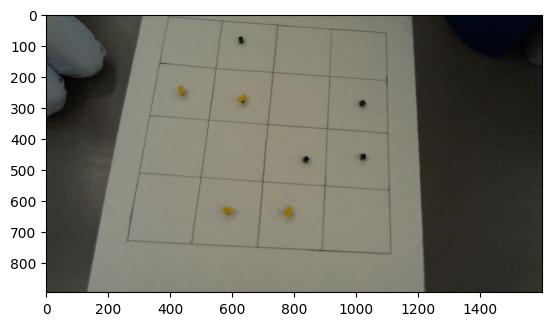

In [146]:
image=imread('/Users/bblais/Desktop/ai373/google/students/Todd_Dilullo_sci373/Images/Robot Pics/image_filename23.jpg')
imshow(image)

In [147]:
def get_gray_and_threshold_image(image,threshold,fill_sides=True):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = image.shape[:2]
    threshold_im=((gray<threshold)*255).astype(np.uint8)

    if fill_sides:
        # fill in the side parts that are off the grid
        val=0
        cv2.floodFill(threshold_im,None,(0,0),val)
        cv2.floodFill(threshold_im,None,(w-1,0),val)
        cv2.floodFill(threshold_im,None,(w-1,h-1),val)
        cv2.floodFill(threshold_im,None,(0,h-1),val)   


    return gray,threshold_im

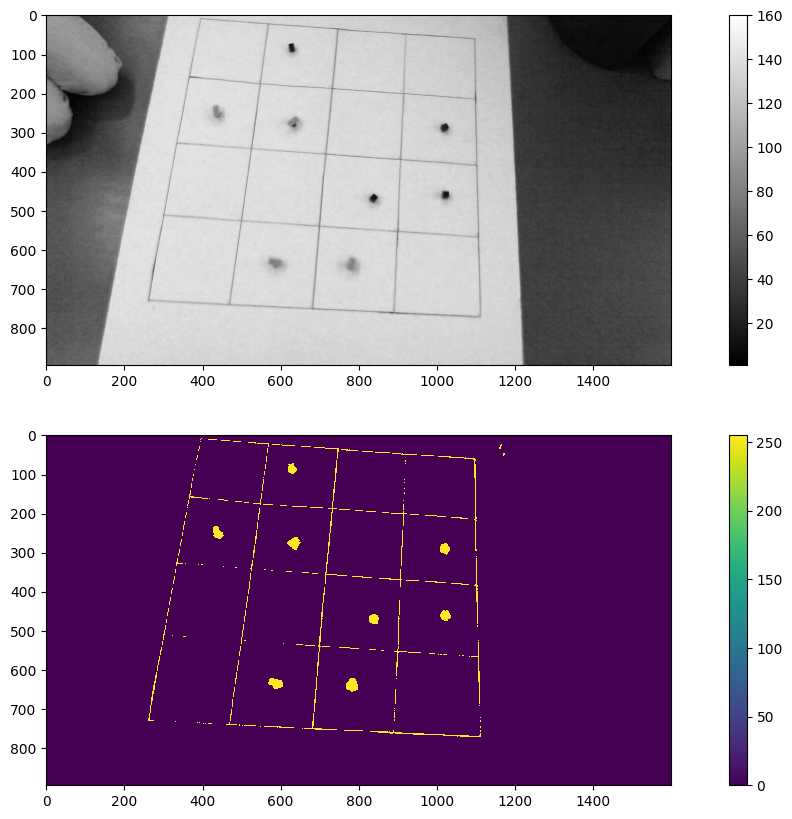

In [148]:
gray,threshold_im=get_gray_and_threshold_image(image,threshold=110)

figure(figsize=(15,10))

subplot(2,1,1)
imshow(gray,cmap=cm.gray)
colorbar()

subplot(2,1,2)
imshow(threshold_im,interpolation='none')
colorbar()


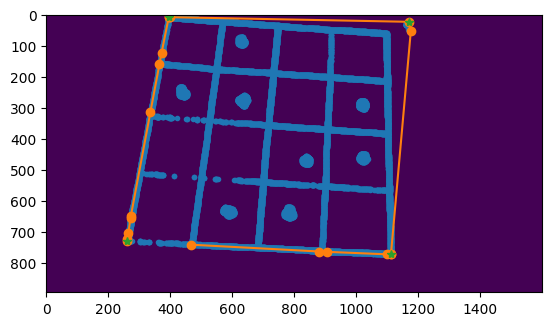

In [149]:
corners=find_corners(threshold_im,plotit=True)

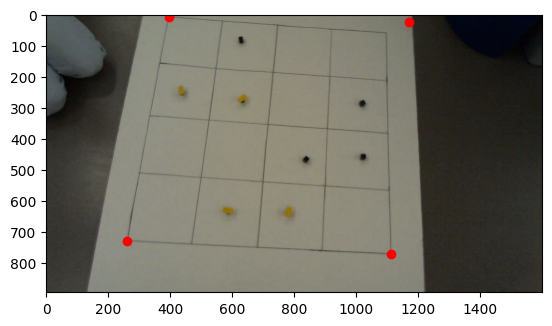

In [150]:
imshow(image)
# corners=array([[ 400.,   10.],
#        [ 1100.,   40.],
#        [250.,  710.],
#        [1111.,  750.]], dtype=float32)

plot(corners[:,0],corners[:,1],'ro')


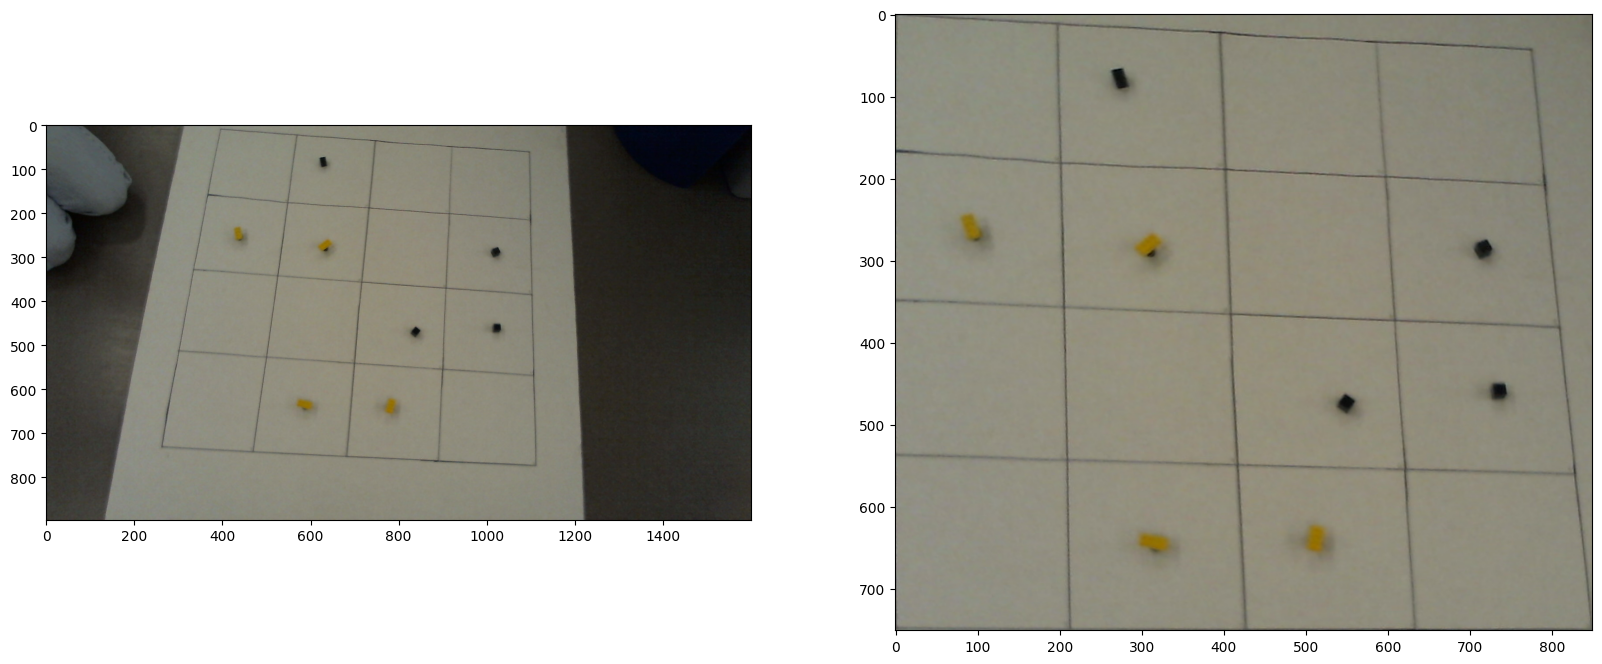

In [154]:
im3=straighten_image(image,corners)
figure(figsize=(20,8))

subplot(1,2,1)
imshow(image)

subplot(1,2,2)
imshow(im3)

In [156]:
from Game import Board
state=Board('0200/1102/0022/0110')
print(state)
squares=get_board_squares_from_image(im3,state.shape)

 0  2  0  0 
 1  1  0  2 
 0  0  2  2 
 0  1  1  0 



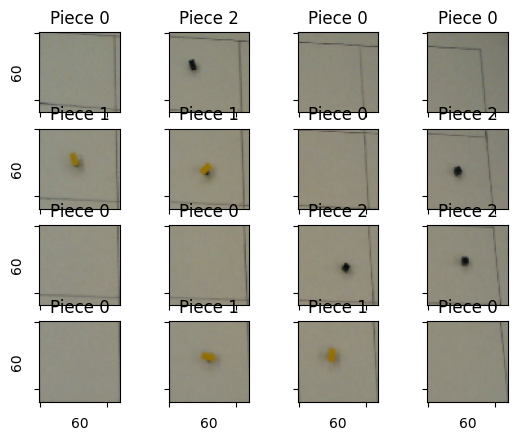

In [157]:
nr,nc=state.shape
saveit=False

count=0
for r in range(nr):
    for c in range(nc):

        subplot(nr,nc,count+1)
        imshow(squares[count])

        shape=squares[count].shape
        piece=state.board[count]
        
        title(f"Piece {piece}")
        if c==0:
            ylabel(shape[0])

        if r==nr-1:
            xlabel(shape[1])
        gca().set_xticklabels([])
        gca().set_yticklabels([])


        if saveit:
            fname=f"images/square{r}_{c}_{piece}.jpg"
            print(fname)
            imsave(fname,squares[count])
        



        
        count+=1        

